<a href="https://colab.research.google.com/github/minashkinvladislav/Frank_Wolfe/blob/main/first_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quadratic function

In [134]:
import shutil
from pathlib import Path
tree = Path()
for file in tree.iterdir():
    if str(file) == "Frank_Wolfe":
        shutil.rmtree("Frank_Wolfe")
import numpy as np
from getpass import getpass
!git clone https://github.com/minashkinvladislav/Frank_Wolfe
from Frank_Wolfe import models
from importlib import reload

Cloning into 'Frank_Wolfe'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 48 (delta 25), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (48/48), 60.14 KiB | 1.13 MiB/s, done.


In [135]:
def f(x, args):
    np.random.seed(args['seed'])
    xi = args['sigma'] * np.random.standard_normal(1)
    return 1./2 * x.T @ args['A'] @ x + xi

def nabla_f_true(x, args):
    return args['A'] @ x

args = {}
args['d'] = 10
args['mu'] = 1
args['L'] = 1000
args['func'] = f
args['seed'] = 18

args['A'] = models.generate_A(args['d'], args['mu'], 
                              args['L'], args['seed'])

np.random.seed(args['seed'])
w_0 = np.random.random_sample(args['d'])
w_0 = np.abs(w_0) / np.linalg.norm(w_0, ord = 1)

# models params
args['batch_size'] = 10
args['sigma'] = 1
args['gamma'] = 1e-6

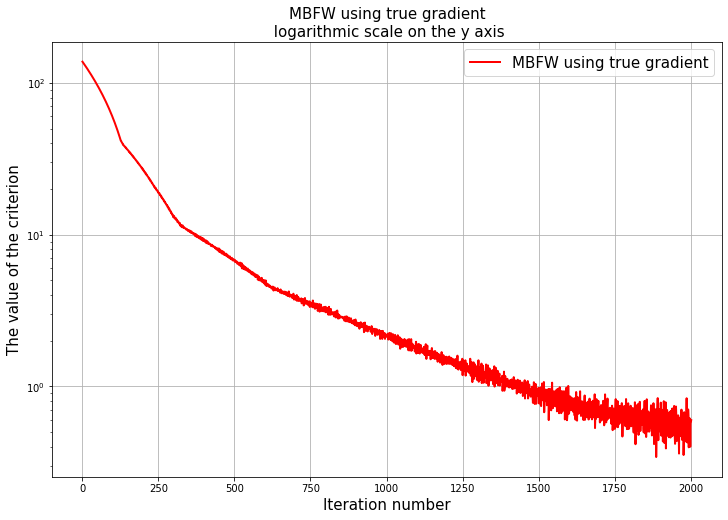

MBFW using true gradient. f(w_sol) = 26.22994


In [136]:
# для зеркального спуска будем брать постоянный шаг 1/L
def const_gamma(k, func, nabla_f, x_curr, x_sol, args):
    return 1. / args['L']

def momentum_k(k, f, nabla_f, x_k, x_sol, args):
    return k/(k+1)

Gradient_Descent = models.GradientDescent(f, nabla_f_true, x_0=w_0, max_steps=2000,
                                          gamma_k=const_gamma, args=args,
                                          criterium='gap', use_mbfw=True, momentum_k=momentum_k)
w_sol, errors_true, _ = Gradient_Descent.search()
itrerations_true = [range(1, len(errors_true) + 1)]
errors_true = [errors_true]
labels_true = ["MBFW using true gradient"]
title = "MBFW using true gradient"
models.make_err_plot(itrerations_true, errors_true, labels_true, title, markers=[None]*100)
print("MBFW using true gradient. f(w_sol) = %.5f" % f(w_sol, args))

# TWO POINT FEEDBACK

## Mirror descent

### Two point feedback

Mirror descent, TPF, norm=1. f(w_sol) = 25.62298             , w_sol in simplex: False, sum: 0.98954


Mirror descent, TPF, norm=2. f(w_sol) = 26.75867             , w_sol in simplex: False, sum: 1.00258


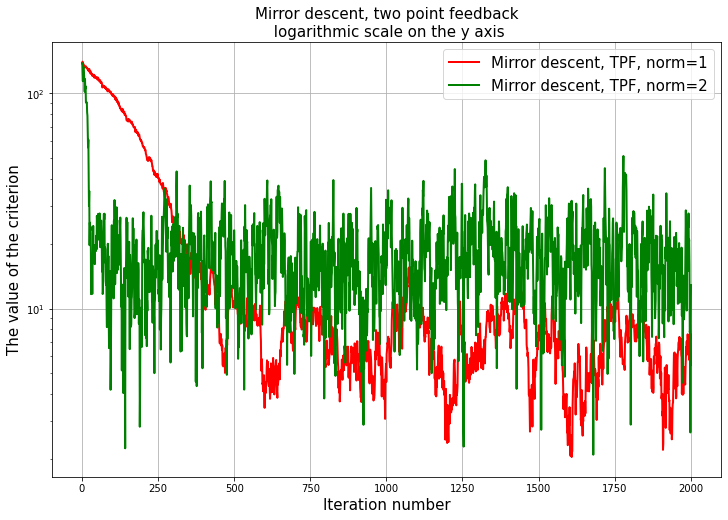

In [137]:
errors_mir_tpf = []
iterations_mir_tpf = []
labels_mir_tpf = []

for norm in [1, 2]:
      args['norm'] = norm
      mirror_descent = models.GradientDescent(f, nabla_f=models.get_grad_tpf, x_0=w_0, 
                                              max_steps=2000, gamma_k=const_gamma, args=args,
                                              nabla_f_true=nabla_f_true,
                                              criterium='gap', use_mirror=True)

      w_sol, errors, _ = mirror_descent.search()
      is_in_simplex = ((w_sol == (np.abs(w_sol))).all() \
                       and (np.linalg.norm(w_sol, ord=1) == 1))
      iterations = range(1, len(errors)+1)
      errors_mir_tpf.append(errors)
      iterations_mir_tpf.append(iterations)
      labels_mir_tpf.append("Mirror descent, TPF, norm=%i" % norm)
      print("Mirror descent, TPF, norm=%i. f(w_sol) = %.5f \
            , w_sol in simplex: %s, sum: %.5f" % (norm, f(w_sol, args), is_in_simplex, sum(w_sol)))

title = "Mirror descent, two point feedback"
models.make_err_plot(iterations_mir_tpf, errors_mir_tpf,
                     labels=labels_mir_tpf, title=title, markers=[None]*100)

## Momentum based FW

### Two point feedback

MBFW, TPF, norm=1. f(w_sol) = 29.01244             , w_sol in simplex: False, sum: 1.00000


MBFW, TPF, norm=2. f(w_sol) = 29.27278             , w_sol in simplex: False, sum: 1.00000


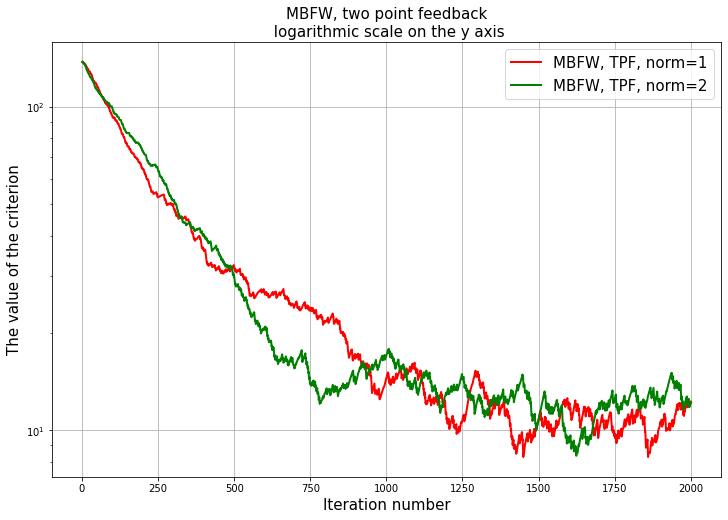

In [138]:
errors_mbfw_tpf = []
iterations_mbfw_tpf = []
labels_mbfw_tpf = []

for norm in [1, 2]:
      args['norm'] = norm
      mirror_descent = models.GradientDescent(f, nabla_f=models.get_grad_tpf, x_0=w_0, 
                                              max_steps=2000, gamma_k=const_gamma, args=args,
                                              nabla_f_true=nabla_f_true,
                                              criterium='gap', use_mbfw=True, 
                                              momentum_k=momentum_k)

      w_sol, errors, _ = mirror_descent.search()
      is_in_simplex = ((w_sol == (np.abs(w_sol))).all() \
                       and (np.linalg.norm(w_sol, ord=1) == 1))
      iterations = range(1, len(errors)+1)
      errors_mbfw_tpf.append(errors)
      iterations_mbfw_tpf.append(iterations)
      labels_mbfw_tpf.append("MBFW, TPF, norm=%i" % norm)
      print("MBFW, TPF, norm=%i. f(w_sol) = %.5f \
            , w_sol in simplex: %s, sum: %.5f" % (norm, f(w_sol, args), is_in_simplex, sum(w_sol)))

title = "MBFW, two point feedback"
models.make_err_plot(iterations_mbfw_tpf, errors_mbfw_tpf,
                     labels=labels_mbfw_tpf, title=title, markers=[None]*100)

## Frank Wolfe
### Two point feedback

FW, TPF, norm=1. f(w_sol) = 29.01135             , w_sol in simplex: False, sum: 1.00000


FW, TPF, norm=2. f(w_sol) = 29.21966             , w_sol in simplex: False, sum: 1.00000


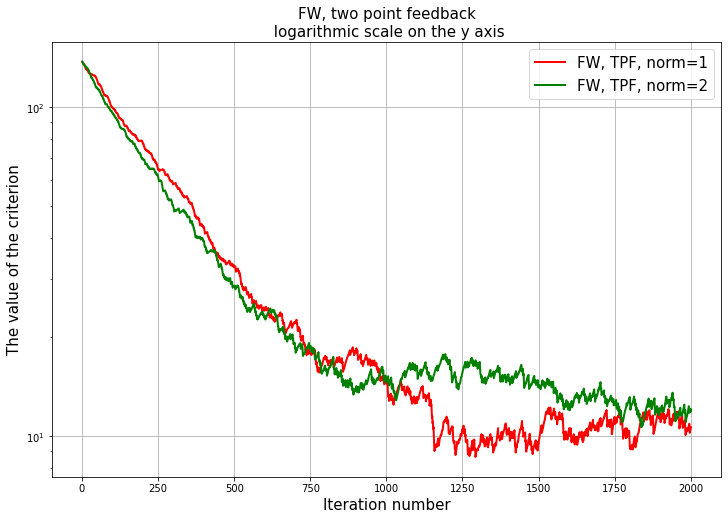

In [139]:
errors_fw_tpf = []
iterations_fw_tpf = []
labels_fw_tpf = []

for norm in [1, 2]:
      args['norm'] = norm
      mirror_descent = models.GradientDescent(f, nabla_f=models.get_grad_tpf, x_0=w_0, 
                                              max_steps=2000, gamma_k=const_gamma, args=args,
                                              nabla_f_true=nabla_f_true,
                                              criterium='gap', use_fw=True)

      w_sol, errors, _ = mirror_descent.search()
      is_in_simplex = ((w_sol == (np.abs(w_sol))).all() \
                       and (np.linalg.norm(w_sol, ord=1) == 1))
      iterations = range(1, len(errors)+1)
      errors_fw_tpf.append(errors)
      iterations_fw_tpf.append(iterations)
      labels_fw_tpf.append("FW, TPF, norm=%i" % norm)
      print("FW, TPF, norm=%i. f(w_sol) = %.5f \
            , w_sol in simplex: %s, sum: %.5f" % (norm, f(w_sol, args), is_in_simplex, sum(w_sol)))

title = "FW, two point feedback"
models.make_err_plot(iterations_fw_tpf, errors_fw_tpf,
                     labels=labels_fw_tpf, title=title, markers=[None]*100)

## Projection
### two point feedback

FW, TPF, norm=1. f(w_sol) = 26.69894             , w_sol in simplex: False, sum: 1.00000


FW, TPF, norm=2. f(w_sol) = 33.93823             , w_sol in simplex: False, sum: 1.00000


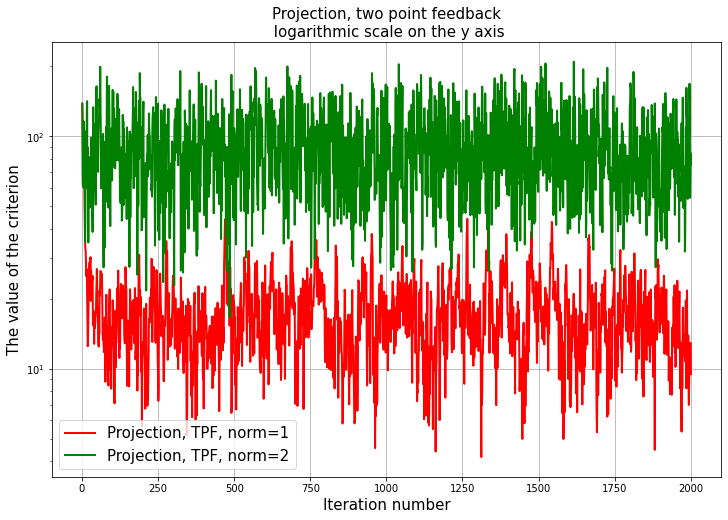

In [140]:
errors_pr_tpf = []
iterations_pr_tpf = []
labels_pr_tpf = []

for norm in [1, 2]:
      args['norm'] = norm
      mirror_descent = models.GradientDescent(f, nabla_f=models.get_grad_tpf, x_0=w_0, 
                                              max_steps=2000, gamma_k=const_gamma, args=args,
                                              nabla_f_true=nabla_f_true,
                                              proj_func = models.GradientDescent.projection,
                                              criterium='gap', use_proj=True)

      w_sol, errors, _ = mirror_descent.search()
      is_in_simplex = ((w_sol == (np.abs(w_sol))).all() \
                       and (np.linalg.norm(w_sol, ord=1) == 1))
      iterations = range(1, len(errors)+1)
      errors_pr_tpf.append(errors)
      iterations_pr_tpf.append(iterations)
      labels_pr_tpf.append("Projection, TPF, norm=%i" % norm)
      print("FW, TPF, norm=%i. f(w_sol) = %.5f \
            , w_sol in simplex: %s, sum: %.5f" % (norm, f(w_sol, args), is_in_simplex, sum(w_sol)))

title = "Projection, two point feedback"
models.make_err_plot(iterations_pr_tpf, errors_pr_tpf,
                     labels=labels_pr_tpf, title=title, markers=[None]*100)

## Results

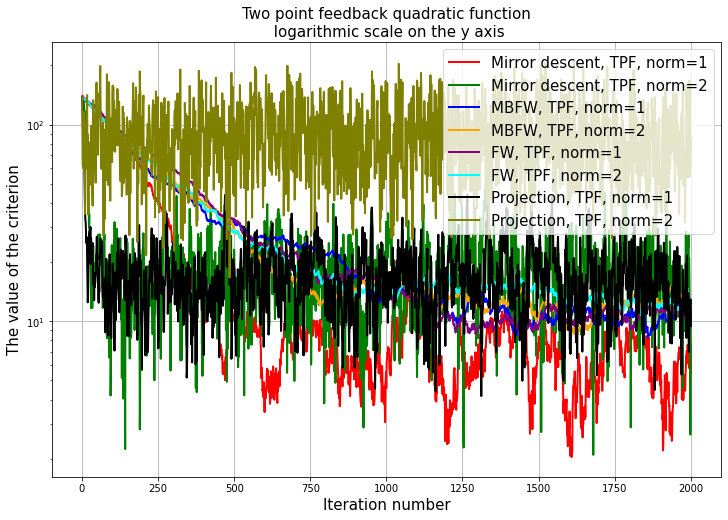

In [141]:
title = "Two point feedback quadratic function"
iterations_tpf = iterations_mir_tpf + iterations_mbfw_tpf + iterations_fw_tpf + iterations_pr_tpf
errors_tpf = errors_mir_tpf + errors_mbfw_tpf + errors_fw_tpf + errors_pr_tpf
labels_tpf = labels_mir_tpf + labels_mbfw_tpf + labels_fw_tpf + labels_pr_tpf
models.make_err_plot(iterations_tpf, errors_tpf,
                     labels=labels_tpf, title=title, markers=[None]*100)

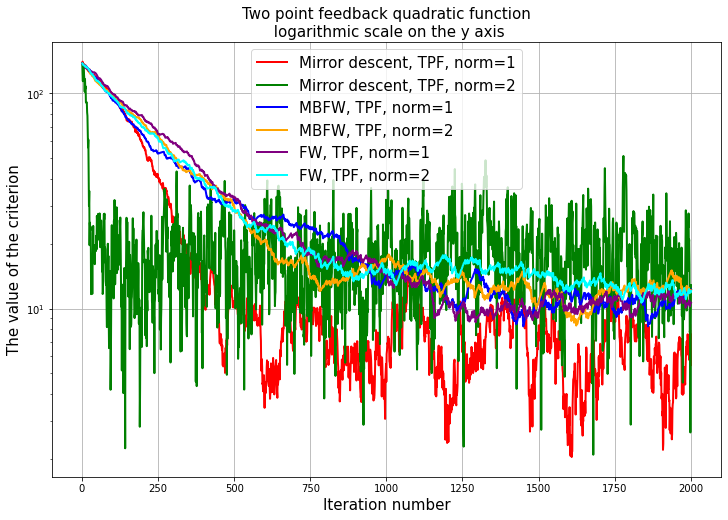

In [142]:
title = "Two point feedback quadratic function"
iterations_tpf = iterations_mir_tpf + iterations_mbfw_tpf + iterations_fw_tpf
errors_tpf = errors_mir_tpf + errors_mbfw_tpf + errors_fw_tpf
labels_tpf = labels_mir_tpf + labels_mbfw_tpf + labels_fw_tpf
models.make_err_plot(iterations_tpf, errors_tpf,
                     labels=labels_tpf, title=title, markers=[None]*100)

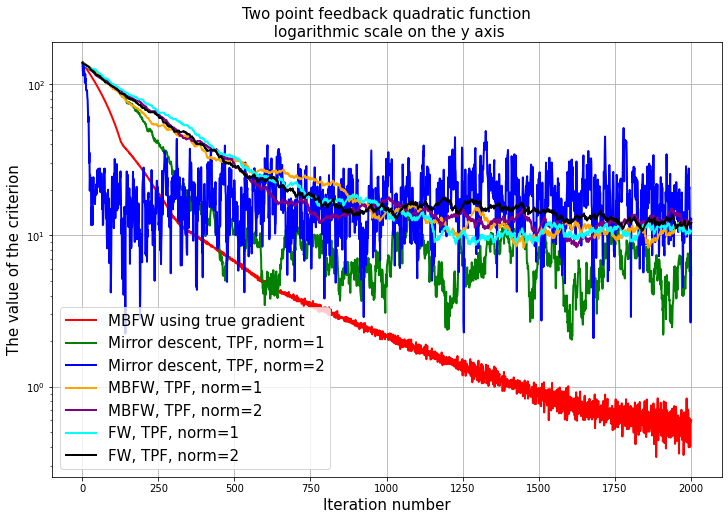

In [143]:
title = "Two point feedback quadratic function"
iterations_tpf = itrerations_true + iterations_mir_tpf + iterations_mbfw_tpf + iterations_fw_tpf
errors_tpf = errors_true + errors_mir_tpf + errors_mbfw_tpf + errors_fw_tpf
labels_tpf = labels_true + labels_mir_tpf + labels_mbfw_tpf + labels_fw_tpf
models.make_err_plot(iterations_tpf, errors_tpf,
                     labels=labels_tpf, title=title, markers=[None]*100)

# ONE POINT FEEDBACK

## Mirror descent

### One point feedback

Mirror descent, OPF, norm=1. f(w_sol) = 26.18384             , w_sol in simplex: False, sum: 1.00132


Mirror descent, OPF, norm=2. f(w_sol) = 27.30836             , w_sol in simplex: False, sum: 1.01787


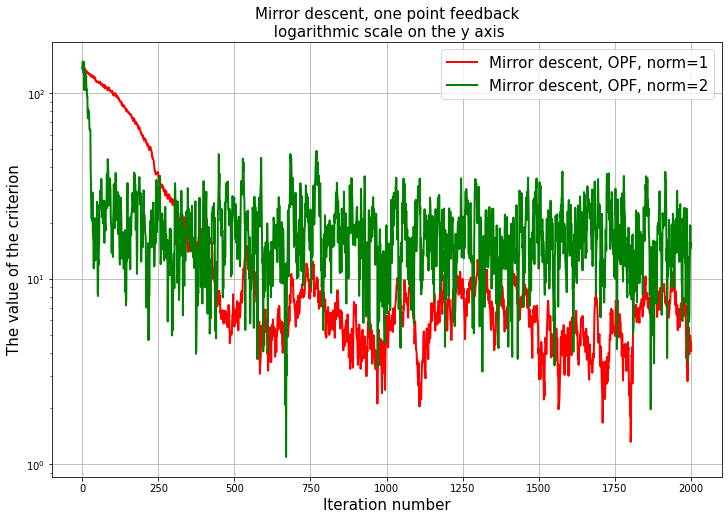

In [144]:
errors_mir_opf = []
iterations_mir_opf = []
labels_mir_opf = []

args['gamma'] = 1e-6

for norm in [1, 2]:
      args['norm'] = norm
      mirror_descent = models.GradientDescent(f, nabla_f=models.get_grad_opf, x_0=w_0, 
                                              max_steps=2000, gamma_k=const_gamma, args=args,
                                              nabla_f_true=nabla_f_true,
                                              criterium='gap', use_mirror=True)

      w_sol, errors, _ = mirror_descent.search()
      is_in_simplex = ((w_sol == (np.abs(w_sol))).all() \
                       and (np.linalg.norm(w_sol, ord=1) == 1))
      iterations = range(1, len(errors)+1)
      errors_mir_opf.append(errors)
      iterations_mir_opf.append(iterations)
      labels_mir_opf.append("Mirror descent, OPF, norm=%i" % norm)
      print("Mirror descent, OPF, norm=%i. f(w_sol) = %.5f \
            , w_sol in simplex: %s, sum: %.5f" % (norm, f(w_sol, args), is_in_simplex, sum(w_sol)))

title = "Mirror descent, one point feedback"
models.make_err_plot(iterations_mir_opf, errors_mir_opf,
                     labels=labels_mir_opf, title=title, markers=[None]*100)

## Momentum based FW

### Two point feedback

MBFW, OPF, norm=1. f(w_sol) = 29.15178             , w_sol in simplex: True, sum: 1.00000


MBFW, OPF, norm=2. f(w_sol) = 29.22390             , w_sol in simplex: False, sum: 1.00000


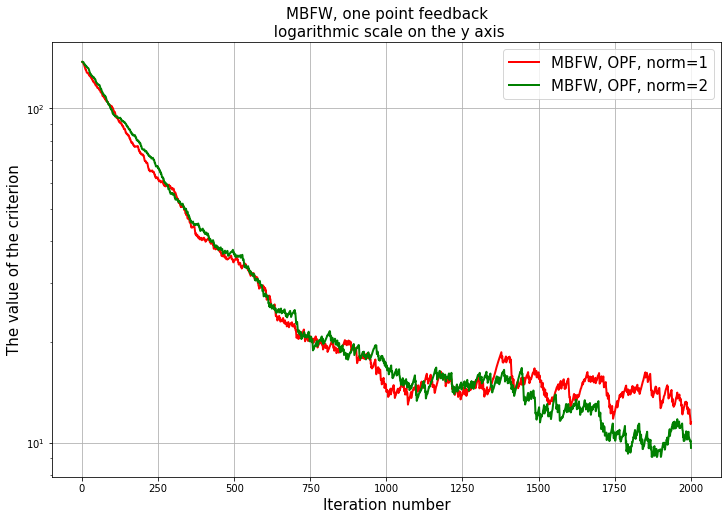

In [145]:
errors_mbfw_opf = []
iterations_mbfw_opf = []
labels_mbfw_opf = []

for norm in [1, 2]:
      args['norm'] = norm
      mirror_descent = models.GradientDescent(f, nabla_f=models.get_grad_opf, x_0=w_0, 
                                              max_steps=2000, gamma_k=const_gamma, args=args,
                                              nabla_f_true=nabla_f_true,
                                              criterium='gap', use_mbfw=True, 
                                              momentum_k=momentum_k)

      w_sol, errors, _ = mirror_descent.search()
      is_in_simplex = ((w_sol == (np.abs(w_sol))).all() \
                       and (np.linalg.norm(w_sol, ord=1) == 1))
      iterations = range(1, len(errors)+1)
      errors_mbfw_opf.append(errors)
      iterations_mbfw_opf.append(iterations)
      labels_mbfw_opf.append("MBFW, OPF, norm=%i" % norm)
      print("MBFW, OPF, norm=%i. f(w_sol) = %.5f \
            , w_sol in simplex: %s, sum: %.5f" % (norm, f(w_sol, args), is_in_simplex, sum(w_sol)))

title = "MBFW, one point feedback"
models.make_err_plot(iterations_mbfw_opf, errors_mbfw_opf,
                     labels=labels_mbfw_opf, title=title, markers=[None]*100)

## Frank Wolfe
### Two point feedback

FW, OPF, norm=1. f(w_sol) = 29.05631             , w_sol in simplex: False, sum: 1.00000


FW, OPF, norm=2. f(w_sol) = 29.11289             , w_sol in simplex: False, sum: 1.00000


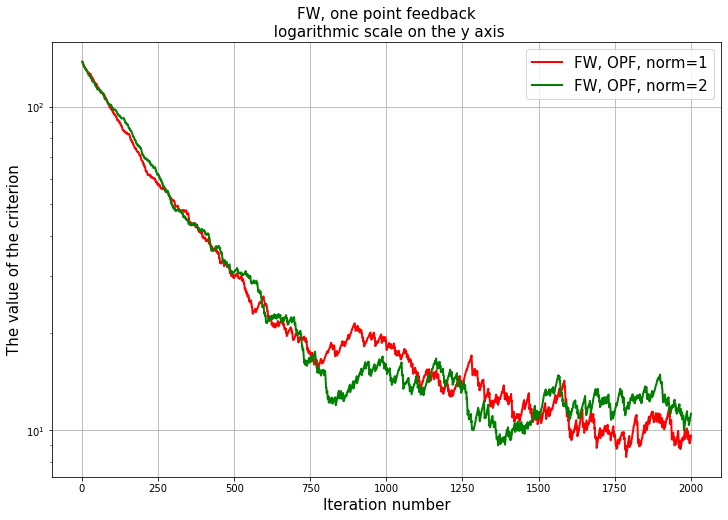

In [146]:
errors_fw_opf = []
iterations_fw_opf = []
labels_fw_opf = []

for norm in [1, 2]:
      args['norm'] = norm
      mirror_descent = models.GradientDescent(f, nabla_f=models.get_grad_opf, x_0=w_0, 
                                              max_steps=2000, gamma_k=const_gamma, args=args,
                                              nabla_f_true=nabla_f_true,
                                              criterium='gap', use_fw=True)

      w_sol, errors, _ = mirror_descent.search()
      is_in_simplex = ((w_sol == (np.abs(w_sol))).all() \
                       and (np.linalg.norm(w_sol, ord=1) == 1))
      iterations = range(1, len(errors)+1)
      errors_fw_opf.append(errors)
      iterations_fw_opf.append(iterations)
      labels_fw_opf.append("FW, OPF, norm=%i" % norm)
      print("FW, OPF, norm=%i. f(w_sol) = %.5f \
            , w_sol in simplex: %s, sum: %.5f" % (norm, f(w_sol, args), is_in_simplex, sum(w_sol)))

title = "FW, one point feedback"
models.make_err_plot(iterations_fw_opf, errors_fw_opf,
                     labels=labels_fw_opf, title=title, markers=[None]*100)

## Projection
### two point feedback

FW, OPF, norm=1. f(w_sol) = 26.41134             , w_sol in simplex: True, sum: 1.00000


FW, OPF, norm=2. f(w_sol) = 45.24052             , w_sol in simplex: True, sum: 1.00000


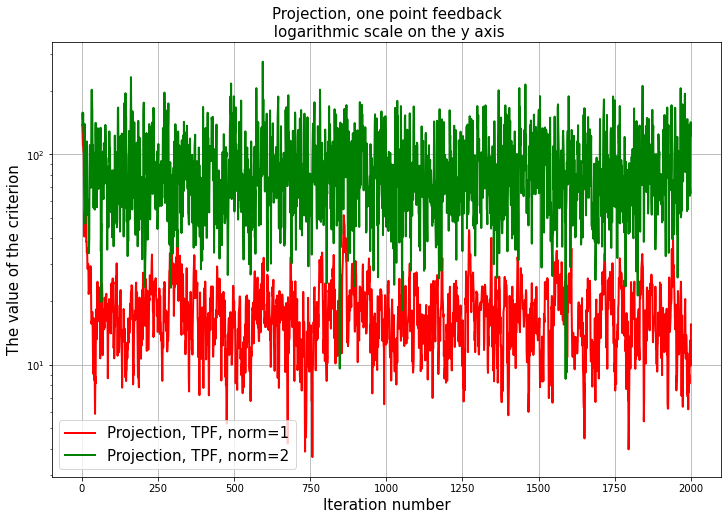

In [147]:
errors_pr_opf = []
iterations_pr_opf = []
labels_pr_opf = []

for norm in [1, 2]:
      args['norm'] = norm
      mirror_descent = models.GradientDescent(f, nabla_f=models.get_grad_opf, x_0=w_0, 
                                              max_steps=2000, gamma_k=const_gamma, args=args,
                                              nabla_f_true=nabla_f_true,
                                              proj_func = models.GradientDescent.projection,
                                              criterium='gap', use_proj=True)

      w_sol, errors, _ = mirror_descent.search()
      is_in_simplex = ((w_sol == (np.abs(w_sol))).all() \
                       and (np.linalg.norm(w_sol, ord=1) == 1))
      iterations = range(1, len(errors)+1)
      errors_pr_opf.append(errors)
      iterations_pr_opf.append(iterations)
      labels_pr_opf.append("Projection, TPF, norm=%i" % norm)
      print("FW, OPF, norm=%i. f(w_sol) = %.5f \
            , w_sol in simplex: %s, sum: %.5f" % (norm, f(w_sol, args), is_in_simplex, sum(w_sol)))

title = "Projection, one point feedback"
models.make_err_plot(iterations_pr_opf, errors_pr_opf,
                     labels=labels_pr_opf, title=title, markers=[None]*100)

## Results

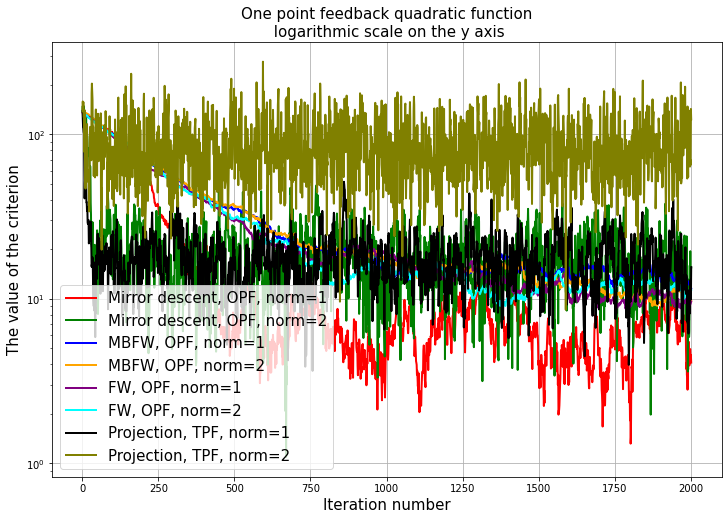

In [148]:
title = "One point feedback quadratic function"
iterations_opf = iterations_mir_opf + iterations_mbfw_opf + iterations_fw_opf + iterations_pr_opf
errors_opf = errors_mir_opf + errors_mbfw_opf + errors_fw_opf + errors_pr_opf
labels_opf = labels_mir_opf + labels_mbfw_opf + labels_fw_opf + labels_pr_opf
models.make_err_plot(iterations_opf, errors_opf,
                     labels=labels_opf, title=title, markers=[None]*100)

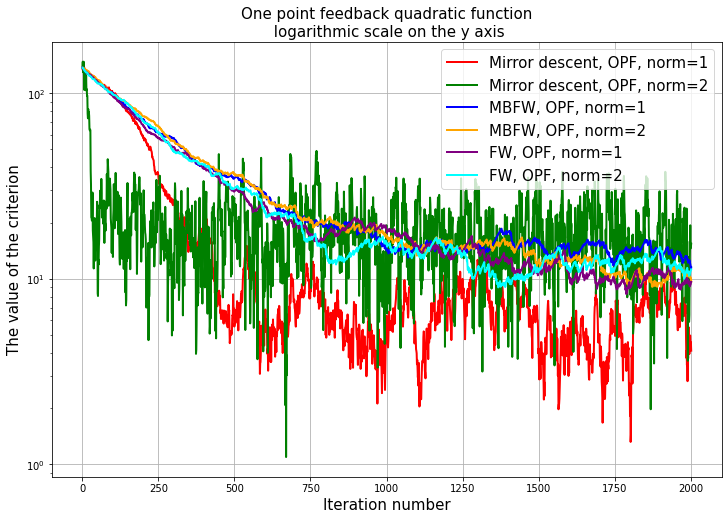

In [149]:
title = "One point feedback quadratic function"
iterations_opf = iterations_mir_opf + iterations_mbfw_opf + iterations_fw_opf
errors_opf = errors_mir_opf + errors_mbfw_opf + errors_fw_opf
labels_opf = labels_mir_opf + labels_mbfw_opf + labels_fw_opf
models.make_err_plot(iterations_opf, errors_opf,
                     labels=labels_opf, title=title, markers=[None]*100)

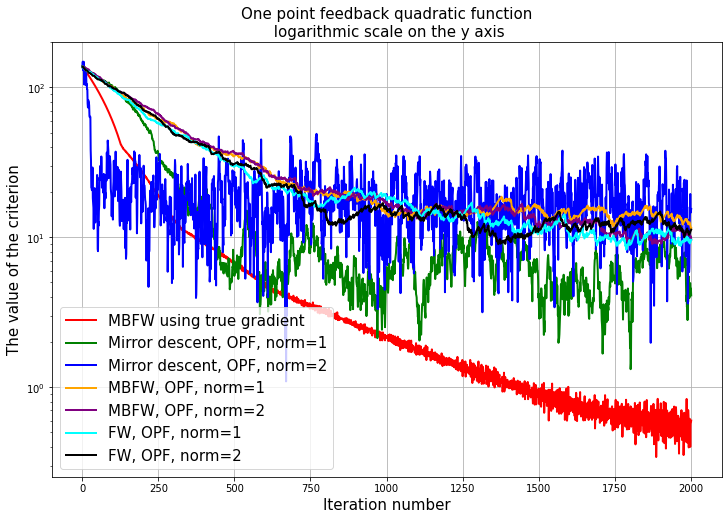

In [150]:
title = "One point feedback quadratic function"
iterations_opf = itrerations_true + iterations_mir_opf + iterations_mbfw_opf + iterations_fw_opf
errors_opf = errors_true + errors_mir_opf + errors_mbfw_opf + errors_fw_opf
labels_opf = labels_true + labels_mir_opf + labels_mbfw_opf + labels_fw_opf
models.make_err_plot(iterations_opf, errors_opf,
                     labels=labels_opf, title=title, markers=[None]*100)